# Language Modeling

In this seminar we will train LM on a collection of names and try to generate new names

In [1]:
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython import display
from itertools import islice

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

## Load data
The dataset contains ~8k names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [3]:
# so that the network knows that we're generating a first token
start_token = "<SOS>"
stop_token = "<EOS>"

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "<PAD>"

with open("names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [name.lower() for name in names]

In [5]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
abagael
claresta
glory
liliane
prissie
geeta
giovanne
piggy


max length: 15


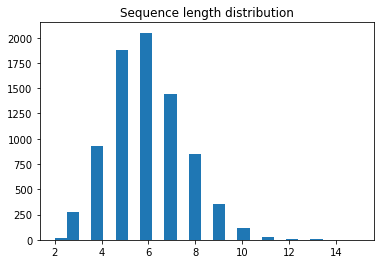

In [6]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

## Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [8]:
tokens = set([
    c
    for name in names
    for c in name
])
tokens = list(tokens)
tokens.extend([start_token, pad_token, stop_token])

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  32


In [9]:
# tokens

In [14]:
token2index = {token: index for index, token in enumerate(tokens)}
index2token = {index: token for token, index in token2index.items()}

In [15]:
tokenizer = lambda name: [token2index[c] for c in name]
decoding = lambda x: "".join([index2token[i] for i in x])

In [16]:
assert decoding(tokenizer('adgfdfknsa')) == 'adgfdfknsa'

In [17]:
class NameDataset(Dataset):
    
    def __init__(self, names):
        self.names = names
    
    def __getitem__(self, index):
        return tokenizer(self.names[index])
    
    def __len__(self):
        return len(self.names)

In [18]:
class Collator:
    
    def __init__(self, pad_value, sos_value, eos_value):
        self.pad_value = pad_value
        self.sos_value = sos_value
        self.eos_value = eos_value
    
    def __call__(self, names):
        max_length = 0
        lengths = []
        
        for name in names:
            max_length = max(max_length, len(name))
            lengths.append(len(name) + 2)

        output = torch.zeros(len(names), max_length + 2).long().fill_(self.pad_value)
        for i, name in enumerate(names):
            output[i, 0] = self.sos_value
            output[i, 1:1 + len(name)] = torch.tensor(name)
            output[i, 1 + len(name)] = self.eos_value
        
        return output, torch.tensor(lengths).long()

In [19]:
dataset = NameDataset(names)

In [20]:
collator = Collator(
    pad_value=token2index[pad_token],
    sos_value=token2index[start_token],
    eos_value=token2index[stop_token]
)
dataloader = DataLoader(dataset, batch_size=32, collate_fn=collator)

In [21]:
list(islice(dataloader, 1))[0]

(tensor([[29, 24, 26, 24, 11, 24,  2, 13, 31, 30],
         [29, 24, 26, 24, 11, 24, 27, 13, 31, 30],
         [29, 24, 26, 26,  2, 31, 30, 30, 30, 30],
         [29, 24, 26, 26,  2, 18, 31, 30, 30, 30],
         [29, 24, 26, 26, 27, 31, 30, 30, 30, 30],
         [29, 24, 26, 26, 27,  2, 31, 30, 30, 30],
         [29, 24, 26, 26, 18, 31, 30, 30, 30, 30],
         [29, 24, 26, 27, 11, 24,  2, 13, 31, 30],
         [29, 24, 26, 27, 11, 24, 27, 13, 31, 30],
         [29, 24, 26, 27, 11, 24, 13,  2, 31, 30],
         [29, 24, 26,  9, 24, 31, 30, 30, 30, 30],
         [29, 24, 10, 24, 10, 27, 24, 31, 30, 30],
         [29, 24, 23, 24, 31, 30, 30, 30, 30, 30],
         [29, 24, 23, 24,  4, 31, 30, 30, 30, 30],
         [29, 24, 23, 24, 13, 27, 16,  2, 31, 30],
         [29, 24, 23, 24,  9, 24, 31, 30, 30, 30],
         [29, 24, 23, 23, 27,  2, 31, 30, 30, 30],
         [29, 24, 23, 23, 27, 21, 31, 30, 30, 30],
         [29, 24, 23,  2, 13, 31, 30, 30, 30, 30],
         [29, 24, 23,  2, 13, 2

In [22]:
decoding(list(islice(dataloader, 1))[0][0][1].tolist())

'<SOS>abagail<EOS><PAD>'

In [24]:
decoding(list(islice(dataloader, 1))[0][0][2].tolist())

'<SOS>abbe<EOS><PAD><PAD><PAD><PAD>'

## Model

In [26]:
class NeuralLM(nn.Module):
    
    def __init__(
        self,
        num_embeddings : int,
        embedding_dim : int,
        padding_index: int,
        hidden_dim: int
    ):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings, embedding_dim=embedding_dim, padding_idx=padding_index)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim, embedding_dim)
        
    def forward(self, input):
        embeddings = self.embedding(input)
        output, _ = self.rnn(embeddings)
        logits = self.clf(output)
        return logits

In [27]:
model = NeuralLM(len(token2index), 32, token2index[pad_token], 64)
model

NeuralLM(
  (embedding): Embedding(32, 32, padding_idx=30)
  (rnn): LSTM(32, 64, batch_first=True)
  (clf): Linear(in_features=64, out_features=32, bias=True)
)

## Training

In [28]:
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
NUM_EPOCH = 10
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = NeuralLM(len(token2index), 32, token2index[pad_token], 128).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=token2index[pad_token])
optimizer = torch.optim.Adam(model.parameters())

history = defaultdict(list)

In [30]:
for epoch in range(30):
    
    train_loss_meter = AverageMeter()
    
    for texts, text_lengths in dataloader:
        texts = texts.to(DEVICE)
        
        logits = model(texts[..., :-1]).transpose(-1, -2)
        loss = criterion(logits, texts[..., 1:])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_meter.update(loss.item())
    
    print(f'Train loss at {epoch} epoch: {train_loss_meter.avg}')

Train loss at 0 epoch: 2.6590297375338143
Train loss at 1 epoch: 2.3692634919561057
Train loss at 2 epoch: 2.283340691083885
Train loss at 3 epoch: 2.2283065850476182
Train loss at 4 epoch: 2.1865232062627036
Train loss at 5 epoch: 2.1516691374491494
Train loss at 6 epoch: 2.1213435006428916
Train loss at 7 epoch: 2.0942566351718215
Train loss at 8 epoch: 2.069476763407389
Train loss at 9 epoch: 2.0464242672824478
Train loss at 10 epoch: 2.0247821338684204
Train loss at 11 epoch: 2.004177553586692
Train loss at 12 epoch: 1.9844787297957394
Train loss at 13 epoch: 1.9655722944612004
Train loss at 14 epoch: 1.9474588986860222
Train loss at 15 epoch: 1.9300515599040142
Train loss at 16 epoch: 1.91341442707552
Train loss at 17 epoch: 1.8975537680239083
Train loss at 18 epoch: 1.8820934377042164
Train loss at 19 epoch: 1.867173293029448
Train loss at 20 epoch: 1.852798933963699
Train loss at 21 epoch: 1.8387410300802514
Train loss at 22 epoch: 1.82504554493839
Train loss at 23 epoch: 1.8118

In [31]:
def generate(prefix='<SOS>', max_length=12):
#     prefix_sos = prefix[:len('<SOS>')]
    prefix = prefix[len('<SOS>'):]
    
    indexes = [token2index['<SOS>']] + tokenizer(prefix)
    indexes = torch.tensor(indexes)[None, :].long()
    
    while len(indexes[0]) <= max_length:
        with torch.no_grad():
            probs = torch.softmax(model(indexes)[0, -1], dim=0)

            next_token_distr = torch.distributions.Categorical(probs=probs)
            new_token = next_token_distr.sample().item()
        
        indexes = indexes.tolist()[0]
        indexes.append(new_token)
        indexes = torch.tensor(indexes)[None, :].long()
        
        if new_token == token2index['<EOS>']:
            break
    
    return decoding(indexes.tolist()[0])

In [65]:
generate('<SOS>mash')

'<SOS>mashy<EOS>'